Author: Hao Xing

In [ ]:
!pip install openai
!pip install langchain
!pip install langchain-chroma
!pip install -U langchain-community
!pip install tiktoken
!pip install unstructured
!pip install --upgrade --force-reinstall pandas scipy numba


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 2.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.1/611.1 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 59.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 86.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.2/284.2 kB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 70.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.6/101.6 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 91.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 kB 3.8 MB/s eta 0:0

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
import os
import openai
import sys
sys.path.append('../..')

os.environ['OPENAI_API_KEY'] = ''

In [ ]:
# Uncomment if you aare using colab. Now we connect the colab notebook to our drive to access the data.
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cd /content/gdrive/MyDrive/Colab Notebooks/MF815/NLP/NLP_app

/content/gdrive/MyDrive/Colab Notebooks/MF815/NLP/NLP_app


In [ ]:
from IPython.display import HTML

In [ ]:
# Progress bar
def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

# read the repo in PATH and append the texts in a list
def get_data(PATH):
    list_dir = os.listdir(PATH)
    texts = []
    fund_names = []
    out = display(progress(0, len(list_dir)-1), display_id=True)
    for ii, filename in enumerate(list_dir) :
        with open(PATH+'/'+filename, 'r', encoding="utf8") as f :
            txt = f.read()
            try :
                txt_split = txt.split('<head_breaker>')
                summary = txt_split[1].strip()
                fund_name = txt_split[0].strip()
            except :
                summary = txt
                fund_name = ''
        texts.append(summary)
        fund_names.append(fund_name)
        out.update(progress(ii, len(list_dir)-1))
    return fund_names, texts

In [ ]:
# Get the summaries
SUMMARY_PATH = '/content/gdrive/MyDrive/Colab Notebooks/MF815/NLP/NLP_app/MutualFundSummary_selected'
fund_names, summaries = get_data(SUMMARY_PATH)

In [ ]:
fund_names

['Western Asset Massachusetts Municipals Fund',
 'Variable Portfolio - Wells Fargo Short Duration Government Fund',
 'World Growth Fund',
 'Variable Portfolio - TCW Core Plus Bond Fund',
 'Western Asset Intermediate Maturity New York Municipals Fund',
 'Variable Portfolio - Victory Sycamore Established Value Fund',
 'Virtus Newfleet Dynamic Credit ETF',
 'Variable Portfolio - T. Rowe Price Large Cap Value Fund',
 'Virtus Enhanced U.S. Equity ETF',
 'Western Asset Intermediate Maturity California Municipals Fund',
 'Variable Portfolio - BlackRock Global Inflation-Protected Securities Fund',
 'Vanguard Ultra-Short-Term Bond Fund',
 'Variable Portfolio - Oppenheimer International Growth Fund',
 'Vanguard Short-Term Treasury Fund',
 'Variable Portfolio - Partners Small Cap Value Fund',
 'Variable Portfolio - MFS Blended Research Core Equity Fund',
 'Variable Portfolio - MFS Value Fund',
 'Vanguard Short-Term Investment-Grade Fund',
 'Vanguard Short-Term Treasury Index Fund',
 'Variable Por

In [ ]:
print(len(fund_names))

70


In [ ]:
SUMMARY_LABELS_PATH = '/content/gdrive/MyDrive/Colab Notebooks/MF815/NLP/NLP_app/MutualFundLabels.csv'

df_extraction = pd.DataFrame({'fund_name' : fund_names})
df_label = pd.read_csv(SUMMARY_LABELS_PATH)
#df = df_label.merge(df_extraction, on='fund_name', how='inner')
df_label = df_label.rename(columns={'Leverage?': 'Derivatives_label'})
df_label

,id,fund_name,Performance fee?,Ivestment Strategy,Derivatives_label,Portfolio composition,Concentration
0,0000051931-18-000151,American Funds College 2018 Fund,NaN,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified
1,0000051931-18-000151,American Funds College 2021 Fund,NaN,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified
2,0000051931-18-000151,American Funds College 2024 Fund,NaN,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified
3,0000051931-18-000151,American Funds College 2027 Fund,NaN,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified
4,0000051931-18-000151,American Funds College 2030 Fund,NaN,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified
...,...,...,...,...,...,...,...
462,0001710607-18-000172,American Century Diversified Corporate Bond ETF,NaN,Fixed Income Long Only (Low Risk),Yes,Investment grade securities,Diversified
463,0001710607-18-000172,American Century Diversified Municipal Bond ETF,NaN,Fixed Income Long Only (Low Risk),No,Investment grade securities,Diversified
464,0001710607-18-000172,American Century Quality Diversified Internati...,NaN,Equity Long Only (Low Risk),Yes,Sub-investment grade securities or emerging ma...,Diversified
465,0001710607-18-000172,American Century STOXX U.S. Quality Growth ETF,NaN,Equity Long Only (Low Risk),Yes,Listed Equities,Diversified


## Ask whether the fund use derivatives

In [ ]:
from langchain.document_loaders import DirectoryLoader

# Load documents from a directory
loader = DirectoryLoader(path="./MutualFundSummary_selected", glob="*.txt")

# Load the text data from the directory
documents = loader.load()

In [ ]:
print(len(documents))

70


In [ ]:
document = documents[0]

In [ ]:
print(document)

page_content='Western Asset Massachusetts Municipals Fund <head_breaker>

Investment objective

The fund seeks to provide Massachusetts investors with as high a level of current income exempt from federal income tax and Massachusetts personal income taxes as is consistent with the preservation of principal.

Fees and expenses of the fund

The accompanying table describes the fees and expenses that you may pay if you buy and hold shares of the fund.

You may qualify for sales charge discounts if you and your family invest, or agree to invest in the future, at least $100,000 in funds distributed through Legg Mason Investor Services, LLC (“LMIS”), the fund’s distributor. More information about these and other discounts is available from your Service Agent, in the fund’s Prospectus on page 24 under the heading “Sales charges,” in the appendix titled “Appendix: Waivers and Discounts Available from Certain Service Agents” on page A-1 of the fund’s Prospectus and in the fund’s Statement of Ad

In [ ]:
from langchain.text_splitter import RecursiveCharacterTextSplitter, CharacterTextSplitter
from langchain_chroma import Chroma
from langchain.vectorstores import Chroma
from langchain.embeddings.openai import OpenAIEmbeddings
embedding = OpenAIEmbeddings()
persist_directory = './docs/chroma'

#llm_name = "gpt-3.5-turbo"
llm_name = "gpt-4o-mini"
print(llm_name)

from langchain.chat_models import ChatOpenAI
llm = ChatOpenAI(model_name=llm_name, temperature=0)
from langchain.chains import RetrievalQA

<ipython-input-13-3c6cfdc9e864>:5: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import OpenAIEmbeddings``.
  embedding = OpenAIEmbeddings()


gpt-4o-mini


<ipython-input-13-3c6cfdc9e864>:13: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import ChatOpenAI``.
  llm = ChatOpenAI(model_name=llm_name, temperature=0)


In [ ]:
r_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=100,
    separators=["\n\n", "\n", "(?<=\. )", " "]
)

In [ ]:
#splits=r_splitter.split_documents(documents)
ii = 4

splits=r_splitter.split_documents([documents[ii]])

fund_name = fund_names[ii]

persist_directory = f"./docs/chroma/{fund_name}"

vectordb = Chroma.from_documents(
  documents=splits,
  embedding=embedding,
  persist_directory=persist_directory
)

vectordb.persist()

print(len(vectordb))

79


In [ ]:
from langchain.prompts import PromptTemplate

In [ ]:
# Build prompt
template = """Use the following pieces of context to answer the question at the end. Please answer Yes or No. If you don't know the answer, just say that you don't know, don't try to make up an answer.
{context}
Question: {question}
Helpful Answer:"""
QA_CHAIN_PROMPT = PromptTemplate.from_template(template)

In [ ]:
qa_chain = RetrievalQA.from_chain_type(
  llm,
  retriever=vectordb.as_retriever(),
  return_source_documents=True,
  chain_type_kwargs={"prompt": QA_CHAIN_PROMPT}
)

In [ ]:

question = f"Does {fund_name}! invest in derivatives, such as swaps, options, forwards, futures, put options, and call options? "
#question = f"Who are the portfolio managers of Ultra-Short Bond Fund?"

result = qa_chain({"query": question})

In [ ]:
result

{'query': 'Does Western Asset Intermediate Maturity New York Municipals Fund! invest in derivatives, such as swaps, options, forwards, futures, put options, and call options? ',
 'result': 'Yes.',
 'source_documents': [Document(metadata={'source': 'MutualFundSummary_selected/Copy of Western Asset Intermediate Maturity New York Municipals Fund.txt'}, page_content='The fund may also invest in securities of other open-end or closed-end investment companies, including exchange-traded funds (“ETFs”), that invest primarily in municipal securities.\n\nInstead of, and/or in addition to, investing directly in particular securities, the fund may use instruments such as derivatives, including options, futures contracts and inverse floating rate instruments issued in tender option bond transactions, and other synthetic instruments that are intended to provide economic exposure to the securities or the issuer or to be used as a hedging technique. The fund may use one or more types of these\n\nWeste

In [ ]:
print(result["source_documents"][0].metadata)

{'source': 'MutualFundSummary_selected/Copy of Western Asset Intermediate Maturity New York Municipals Fund.txt'}


In [ ]:
df_RAG = pd.DataFrame(fund_names, columns=['fund_name'])
df_RAG['Predicted derivatives'] = np.nan
df_RAG['derivative evidence'] = np.nan
df_RAG['source meta data'] = np.nan

In [ ]:
df_RAG

,fund_name,Predicted derivatives,derivative evidence,source meta data
0,Western Asset Massachusetts Municipals Fund,NaN,NaN,NaN
1,Variable Portfolio - Wells Fargo Short Duratio...,NaN,NaN,NaN
2,World Growth Fund,NaN,NaN,NaN
3,Variable Portfolio - TCW Core Plus Bond Fund,NaN,NaN,NaN
4,Western Asset Intermediate Maturity New York M...,NaN,NaN,NaN
...,...,...,...,...
65,T. Rowe Price Emerging Markets Stock Fund,NaN,NaN,NaN
66,T. Rowe Price Institutional Emerging Markets E...,NaN,NaN,NaN
67,T. Rowe Price Institutional Emerging Markets B...,NaN,NaN,NaN
68,T. Rowe Price Institutional Frontier Markets E...,NaN,NaN,NaN


In [ ]:
for ii in range(len(df_RAG)):
  print(ii)

  fund_name = df_RAG.iloc[ii]['fund_name']

  print(fund_name)

  splits=r_splitter.split_documents([documents[ii]])

  persist_directory = f"./docs/chroma/{fund_name}"

  vectordb = Chroma.from_documents(
    documents=splits,
    embedding=embedding,
    persist_directory=persist_directory
  )

  vectordb.persist()

  print(len(vectordb))

  # Build prompt
  template = """Use the following pieces of context to answer the question at the end. Please answer Yes or No.
  {context}
  Question: {question}
  Helpful Answer:"""
  QA_CHAIN_PROMPT = PromptTemplate.from_template(template)

  qa_chain = RetrievalQA.from_chain_type(
    llm,
    retriever=vectordb.as_retriever(),
    return_source_documents=True,
    chain_type_kwargs={"prompt": QA_CHAIN_PROMPT}
  )

  question = f"Does {fund_name}! invest in derivatives, such as swaps, options, forwards, futures, put options, and call options?"


  result = qa_chain({"query": question})

  #print(result["result"])

  df_RAG.iloc[ii, 1] = result["result"]

  df_RAG.iloc[ii, 2] = result["source_documents"][0].page_content

  df_RAG.iloc[ii, 3] = str(result["source_documents"][0].metadata)


0
Western Asset Massachusetts Municipals Fund
198


<ipython-input-19-bd040449105f>:39: LangChainDeprecationWarning: The method `Chain.__call__` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  result = qa_chain({"query": question})
<ipython-input-19-bd040449105f>:43: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Yes' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_RAG.iloc[ii, 1] = result["result"]
<ipython-input-19-bd040449105f>:45: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'The fund may also engage in a variety of transactions using derivatives in order to change the investment characteristics of its portfolio (such as shortening or lengthening duration) and for other purposes. The fund may leverage its assets by investing proceeds received through tender option

Western Asset Ma

1
Variable Portfolio - Wells Fargo Short Duration Government Fund
120
2
World Growth Fund
105
3
Variable Portfolio - TCW Core Plus Bond Fund
240
4
Western Asset Intermediate Maturity New York Municipals Fund
198
5
Variable Portfolio - Victory Sycamore Established Value Fund
97
6
Virtus Newfleet Dynamic Credit ETF
112
7
Variable Portfolio - T. Rowe Price Large Cap Value Fund
123
8
Virtus Enhanced U.S. Equity ETF
58
9
Western Asset Intermediate Maturity California Municipals Fund
146
10
Variable Portfolio - BlackRock Global Inflation-Protected Securities Fund
167
11
Vanguard Ultra-Short-Term Bond Fund
67
12
Variable Portfolio - Oppenheimer International Growth Fund
164
13
Vanguard Short-Term Treasury Fund
92
14
Variable Portfolio - Partners Small Cap Value Fund
96
15
Variable Portfolio - MFS Blended Research Core Equity Fund
120
16
Variable Portfolio - MFS Value Fund
90
17
Vanguard Short-Term Investment-Grade Fund
116
18
Vanguard Short-Term Treasury Index Fund
49
19
Variable Portfolio - 

In [ ]:
pd.set_option('display.max_colwidth', None)

In [ ]:
df_RAG

,fund_name,Predicted derivatives,derivative evidence,source meta data
0,Western Asset Massachusetts Municipals Fund,Yes,"The fund may also engage in a variety of transactions using derivatives in order to change the investment characteristics of its portfolio (such as shortening or lengthening duration) and for other purposes. The fund may leverage its assets by investing proceeds received through tender option\n\nWestern Asset Massachusetts Municipals Fund\t \t3 Table of Contents bond transactions, which is considered a form of borrowing. See “More on the fund’s investment strategies, investments and risks—Tender option bonds” in this Prospectus.\n\nThe fund is classified as “non-diversified,” which means it may invest a larger percentage of its assets in a smaller number of issuers than a diversified fund.\n\nPrincipal risks",{'source': 'MutualFundSummary_selected/Copy of Western Asset Massachusetts Municipals Fund.txt'}
1,Variable Portfolio - Wells Fargo Short Duration Government Fund,Yes,"Table of Contents VARIABLE PORTFOLIO FUNDS SUMMARY OF CTIVPSM – WELLS FARGO SHORT DURATION GOVERNMENT FUND (continued) Derivatives Risk. Derivatives may involve significant risks. Derivatives are financial instruments with a value in relation to, or derived from, the value of an underlying asset(s) or other reference, such as an index, rate or other economic indicator (each an underlying reference). Derivatives may include those that are privately placed or otherwise exempt from SEC registration, including certain Rule 144A eligible securities. Derivatives could result in Fund losses if the underlying reference does not perform as anticipated. Use of derivatives is a highly specialized activity that can involve investment techniques, risks, and tax planning different from those associated with more traditional investment instruments. The Fund’s derivatives strategy may not be successful and use of certain derivatives could result in substantial, potentially unlimited, losses to the",{'source': 'MutualFundSummary_selected/Copy of Variable Portfolio - Wells Fargo Short Duration Government Fund.txt'}
2,World Growth Fund,No.,World Growth Fund\n\n<head_breaker>,{'source': 'MutualFundSummary_selected/Copy of World Growth Fund.txt'}
3,Variable Portfolio - TCW Core Plus Bond Fund,Yes,"Variable Portfolio - TCW Core Plus Bond Fund <head_breaker>\n\nSUMMARY OF CTIVPSM – TCW CORE PLUS BOND FUND Investment Objective CTIVPSM – TCW Core Plus Bond Fund (the Fund) seeks to provide shareholders with total return through current income and capital appreciation. Fees and Expenses of the Fund This table describes the fees and expenses that you may pay as an investor in the Fund. The table does not reflect any fees or expenses imposed by your Contract or Qualified Plan, which are disclosed in your separate Contract prospectus or Qualified Plan disclosure documents. If the additional fees or expenses were reflected, the expenses set forth below would be higher.",{'source': 'MutualFundSummary_selected/Copy of Variable Portfolio - TCW Core Plus Bond Fund.txt'}
4,Western Asset Intermediate Maturity New York Municipals Fund,Yes,"The fund may also invest in securities of other open-end or closed-end investment companies, including exchange-traded funds (“ETFs”), that invest primarily in municipal securities.\n\nInstead of, and/or in addition to, investing directly in particular securities, the fund may use instruments such as derivatives, including options, futures contracts and inverse floating rate instruments issued in tender option bond transactions, and other synthetic instruments that are intended to provide economic exposure to the securities or the issuer or to be used as a hedging technique. The fund may use one or more types of these\n\nWestern Asset Intermediate Maturity New York Municipals Fund\t \t3 Table of Contents instruments without limit, except that these instruments are taken into account when determining compliance with the fund’s 80% policy. Fo

In [ ]:
def replace_with_value(value):
    if value.startswith('Yes'):
        return 1
    elif value.startswith('No'):
        return 0
    else:
        return np.nan
    return value

In [ ]:
df_RAG['Prediction'] = df_RAG['Predicted derivatives'].apply(replace_with_value)
# df['Derivatives_label'] = df['Derivatives_label'].apply(replace_with_value)

In [ ]:
df_RAG

,fund_name,Predicted derivatives,derivative evidence,source meta data,Prediction
0,Western Asset Massachusetts Municipals Fund,Yes,"The fund may also engage in a variety of transactions using derivatives in order to change the investment characteristics of its portfolio (such as shortening or lengthening duration) and for other purposes. The fund may leverage its assets by investing proceeds received through tender option\n\nWestern Asset Massachusetts Municipals Fund\t \t3 Table of Contents bond transactions, which is considered a form of borrowing. See “More on the fund’s investment strategies, investments and risks—Tender option bonds” in this Prospectus.\n\nThe fund is classified as “non-diversified,” which means it may invest a larger percentage of its assets in a smaller number of issuers than a diversified fund.\n\nPrincipal risks",{'source': 'MutualFundSummary_selected/Copy of Western Asset Massachusetts Municipals Fund.txt'},1
1,Variable Portfolio - Wells Fargo Short Duration Government Fund,Yes,"Table of Contents VARIABLE PORTFOLIO FUNDS SUMMARY OF CTIVPSM – WELLS FARGO SHORT DURATION GOVERNMENT FUND (continued) Derivatives Risk. Derivatives may involve significant risks. Derivatives are financial instruments with a value in relation to, or derived from, the value of an underlying asset(s) or other reference, such as an index, rate or other economic indicator (each an underlying reference). Derivatives may include those that are privately placed or otherwise exempt from SEC registration, including certain Rule 144A eligible securities. Derivatives could result in Fund losses if the underlying reference does not perform as anticipated. Use of derivatives is a highly specialized activity that can involve investment techniques, risks, and tax planning different from those associated with more traditional investment instruments. The Fund’s derivatives strategy may not be successful and use of certain derivatives could result in substantial, potentially unlimited, losses to the",{'source': 'MutualFundSummary_selected/Copy of Variable Portfolio - Wells Fargo Short Duration Government Fund.txt'},1
2,World Growth Fund,No.,World Growth Fund\n\n<head_breaker>,{'source': 'MutualFundSummary_selected/Copy of World Growth Fund.txt'},0
3,Variable Portfolio - TCW Core Plus Bond Fund,Yes,"Variable Portfolio - TCW Core Plus Bond Fund <head_breaker>\n\nSUMMARY OF CTIVPSM – TCW CORE PLUS BOND FUND Investment Objective CTIVPSM – TCW Core Plus Bond Fund (the Fund) seeks to provide shareholders with total return through current income and capital appreciation. Fees and Expenses of the Fund This table describes the fees and expenses that you may pay as an investor in the Fund. The table does not reflect any fees or expenses imposed by your Contract or Qualified Plan, which are disclosed in your separate Contract prospectus or Qualified Plan disclosure documents. If the additional fees or expenses were reflected, the expenses set forth below would be higher.",{'source': 'MutualFundSummary_selected/Copy of Variable Portfolio - TCW Core Plus Bond Fund.txt'},1
4,Western Asset Intermediate Maturity New York Municipals Fund,Yes,"The fund may also invest in securities of other open-end or closed-end investment companies, including exchange-traded funds (“ETFs”), that invest primarily in municipal securities.\n\nInstead of, and/or in addition to, investing directly in particular securities, the fund may use instruments such as derivatives, including options, futures contracts and inverse floating rate instruments issued in tender option bond transactions, and other synthetic instruments that are intended to provide economic exposure to the securities or the issuer or to be used as a hedging technique. The fund may use one or more types of these\n\nWestern Asset Intermediate Maturity New York Municipals Fund\t \t3 Table of Contents instruments without limit, except that these instruments are taken into account when determining compliance with the fu

In [ ]:
df_summary = df_label.merge(df_RAG, on='fund_name', how='inner')

In [ ]:
df_summary

,id,fund_name,Performance fee?,Ivestment Strategy,Derivatives_label,Portfolio composition,Concentration,Predicted derivatives,derivative evidence,source meta data,Prediction
0,0000051931-18-000465,U.S. Government/AAA-Rated Securities Fund,NaN,Fixed Income Long Only (Low Risk),Yes,Investment grade securities,Diversified,Yes,"Instead of, and/or in addition to, investing directly in particular securities, the fund may use instruments such as derivatives, including options, futures contracts and inverse floating rate instruments issued in tender option bond transactions, and other synthetic instruments that are intended to provide economic exposure to the securities or the issuer or to be used as a hedging technique. The fund may use one or more types of these instruments without limit, except that these instruments are taken into account when determining compliance with the fund’s 80% policy. For additional information regarding derivatives, see “More on the fund’s investment strategies, investments and risks—Derivatives” in this Prospectus.",{'source': 'MutualFundSummary_selected/Copy of Western Asset Massachusetts Municipals Fund.txt'},1
1,0000051931-18-000465,Ultra-Short Bond Fund,NaN,Fixed Income Long Only (Low Risk),No,Investment grade securities,Diversified,No.,"Table of Contents VARIABLE PORTFOLIO FUNDS SUMMARY OF CTIVPSM – WELLS FARGO SHORT DURATION GOVERNMENT FUND (continued) Derivatives Risk. Derivatives may involve significant risks. Derivatives are financial instruments with a value in relation to, or derived from, the value of an underlying asset(s) or other reference, such as an index, rate or other economic indicator (each an underlying reference). Derivatives may include those that are privately placed or otherwise exempt from SEC registration, including certain Rule 144A eligible securities. Derivatives could result in Fund losses if the underlying reference does not perform as anticipated. Use of derivatives is a highly specialized activity that can involve investment techniques, risks, and tax planning different from those associated with more traditional investment instruments. The Fund’s derivatives strategy may not be successful and use of certain derivatives could result in substantial, potentially unlimited, losses to the",{'source': 'MutualFundSummary_selected/Copy of Variable Portfolio - Wells Fargo Short Duration Government Fund.txt'},0
2,0000100334-18-000027,ULTRA FUND,NaN,Equity Long Only (Low Risk),No,Listed Equities,Diversified,No.,"Although the portfolio managers intend to invest the fund’s assets primarily in U.S. securities, the fund may invest in securities of foreign companies when these securities meet the portfolio managers’ standards of selection.\n\nThe fund may write covered calls on a portion of the fund’s holdings in common stock when the portfolio managers believe call premiums are attractive relative to the price of the underlying security.\n\nPrincipal Risks\n\nGrowth Stocks — Investments in growth stocks may be more volatile than other stocks and the overall stock market. These stocks are typically priced higher than other stocks because of their growth potential, which may or may not be realized.\n\nStyle Risk — If at any time the market is not favoring the fund’s growth investment style, the fund’s gains may not be as big as, or its losses may be bigger than, those of other equity funds using different investment styles.",{'source': 'MutualFundSummary_selected/Copy of ULTRA FUND.txt'},0
3,0000313212-18-000025,T. Rowe Price Africa & Middle East Fund,NaN,Equity Long Only (Low Risk),No,Sub-investment grade securities or emerging markets,Concentrated by issuer / sector / jurisdiction,Yes,"T. Rowe Price Africa & Middle East Fund <head_breaker>\n\nInvestment Objective\n\nThe fund seeks long-term growth of capital by investing primarily in the common stocks of companies located (or with primary operations) in Africa and the Middle East.\n\nFees and Expenses\n\nThis table describes the fee

In [ ]:
df_summary['label'] = df_summary['Derivatives_label'].apply(replace_with_value)

In [ ]:
pip install scikit-learn

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
df2 = df_summary.dropna(subset = ['label', 'Prediction'])

In [ ]:
cm = confusion_matrix(df2['label'], df2['Prediction'])
print(cm)

[[34  4]
 [ 9  9]]


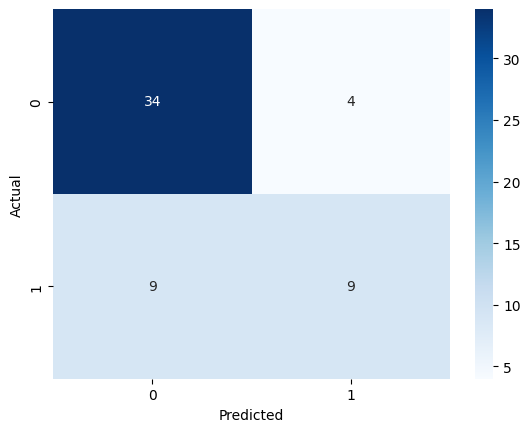

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
